# Redes Neuronales - TP2
## Ej 4
- a - Implemente una red con aprendizaje Backpropagation que aprenda la siguiente
función:

$$f (x , y , z)=sin(x)+cos(y)+z$$

donde: x e y ∊ [0,2 π] y z ∊[−1,1]. Para ello construya un conjunto de datos de entrenamiento y un conjunto de evaluación. Muestre la evolución del error  e
entrenamiento y de evaluación en función de las épocas de entrenamiento.

- b - Estudie la evolución de los errores durante el entrenamiento de una red con una capa oculta de 30 neuronas cuando el conjunto de entrenamiento contiene 40 muestras. ¿Que ocurre si el minibatch tiene tamaño 40? ¿Y si tiene tamaño 1?

Acá la consigna lo lo explicita pero hay que aplicar algo de minibatch al lagoritmo de aprendizaje.

Robando de un post de stackExchange:

batch gradient descent you process the entire training set in one iteration. Whereas, in a mini-batch gradient descent you process a small subset of the training set in each iteration.

Also compare stochastic gradient descent, where you process a single example from the training set in each iteration.

Another way to look at it: they are all examples of the same approach to gradient descent with a batch size of m and a training set of size n. For stochastic gradient descent, m=1. For batch gradient descent, m = n. For mini-batch, m=b and b < n, typically b is small compared to n.

Mini-batch adds the question of determining the right size for b, but finding the right b may greatly improve your results.




Dicho todo esto, la idea es tomar el set de datos y generar batches de entrenamiento. Es otro loop for y una partición de los datos de entrada. hay 2 hiperparams -> la # de minibatches y la # de veces que hacemos el proceso. Para mantener la cantidad de muestras balanceadas, solo se le pueden mostrar 1 vez por batch de minibatch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Vamos a generar las muestras de la función. Voy a barrer X, Y de 0 a 2pi para Z=+-1

In [ ]:
x = np.linspace(0,1,num=200)*2*np.pi
y = x # hasta ahora tenemos los ejes
z = [-1,1]
f = []
tripletas_xyz = []

for k in z:
    for i in x:
        for j in y:
            tripletas_xyz.append([i,j,k])


# este es el dataset entero, es gigante.

# -> lo pasamos a matriz

dataset = np.asmatrix(tripletas_xyz) # listo.

# no lo shuffleo acá, es lo va a hacer el entrenador
# voy a generar el f

f = np.sin(dataset[:,0])+np.cos(dataset[:,1])+dataset[:,2]




Ahora toca shufflear las filas y hacer dataset de entrenamiento y de testeo. Por comodidad lo hago con sklearn, el resto si será a mano. Como tengo 80mil registros, y quiero batches de números enteros, voy a separar esto en una proporción 70% 30%, que me parece razonable. Luego, los minibatches serán de números como 1,10,100,1000,2000,4000.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(  dataset, f, train_size = 56000, random_state=0)

In [ ]:
class perceptron_multicapa:
    def __init__(self, capas, dim_entrada):
        self.capas = capas
        self.dim_entrada = dim_entrada
        self.lista_matrices = []
        self.lr = None
        entrada_anterior = dim_entrada
        for num_perceptrones in capas:
            matriz_pesos = np.random.uniform(-2, 2, size=(num_perceptrones, entrada_anterior + 1)) # inicialización más amplia
            self.lista_matrices.append(matriz_pesos)
            entrada_anterior = num_perceptrones

    def funcion_activacion(self, x):
        return 1 / (1 + np.exp(-x))

    def derivada_activacion(self, a):
        return a * (1 - a)

    def forward(self, x):
        a = x
        activaciones = [a] # todos los x de la red cuando se propaga para adelante - es el zs pasado por la función de activación
        zs = []# todos los h de la red cuando se propaga para adelante
        for W in self.lista_matrices:
            a_b = np.concatenate(([1], a))
            z = np.dot(W, a_b)
            zs.append(z)
            a = self.funcion_activacion(z)
            activaciones.append(a)
        return activaciones, zs

    def predecir(self, X):
        salidas = []
        for x in X:
            a = x
            for W in self.lista_matrices:
                a = np.concatenate(([1], a))
                a = self.funcion_activacion(np.dot(W, a))
            salidas.append(a.reshape(-1))  # garantiza que sea vector 1D
        return np.array(salidas).reshape(len(X), -1)

    def predecir_hard(self, X):
        salidas = self.predecir(X)
        # Si la salida es entre 0 y 1 (sigmoide), umbral en 0.5
        return (salidas >= 0.5).astype(int)

    def entrenar(self, X, Y, lr=1.0, epochs=100):
        self.lr = lr
        n_samples = X.shape[0]
        self.error_por_epoch = []
        for epoch in range(epochs):
            grad_acum = [np.zeros_like(W) for W in self.lista_matrices]
            for i in range(n_samples):
                x = X[i]
                y = Y[i]
                activaciones, zs = self.forward(x) # tomo los h y x del paso foward
                deltas = [None] * len(self.lista_matrices) # lugar para guardar los deltas
                a_out = activaciones[-1] # la activavión de la salida es la última
                deltas[-1] = (a_out - y) * self.derivada_activacion(a_out) # el último delta es el de la salida, y se calcula como la salida deseada - la actual por la derivada de la func de act.
                for l in range(len(self.lista_matrices)-2, -1, -1): # acá propagamos desde la salida para aras
                    W_next = self.lista_matrices[l+1][:,1:]
                    delta_next = deltas[l+1]
                    a_l = activaciones[l+1]
                    deltas[l] = np.dot(W_next.T, delta_next) * self.derivada_activacion(a_l)
                for l in range(len(self.lista_matrices)):
                    a_prev = np.concatenate(([1], activaciones[l]))
                    grad_acum[l] += np.outer(deltas[l], a_prev)
            for l in range(len(self.lista_matrices)):
                self.lista_matrices[l] -= self.lr * grad_acum[l] / n_samples
            if epoch % 100 == 0 or epoch == epochs-1:
                pred = self.predecir(X)
                loss = np.mean((pred - Y) ** 2) # acá se va guardando el ECM para luego visualizarlo, pero se hace cada tanto, no los miles de puntos.
                self.error_por_epoch.append(loss)

    def minibatch_training(self, X, Y, tamanio, veces, lr=0.1, epochs=100, X_val=None, Y_val=None, eval_every=1, verbose=False):
        """
        Minibatch training wrapper.
        - X, Y: training data (ndarray)
        - tamanio: tamaño del minibatch (int)
        - veces: número de pasadas (epochs sobre el dataset, int)
        - lr, epochs: parámetros pasados a `entrenar` para cada minibatch
        - X_val, Y_val: si se pasan, se calcula ECM sobre validación cada `eval_every` batches
        - eval_every: frecuencia en batches para evaluar en validación (>=1)
        - verbose: si True imprime progreso resumido
        """
        # asegurar arrays numpy en caso de recibir matrices
        X = np.asarray(X)
        Y = np.asarray(Y)
        if X_val is not None and Y_val is not None:
            X_val = np.asarray(X_val)
            Y_val = np.asarray(Y_val)

        n_samples = X.shape[0]
        self.train_error_progress = []
        self.val_error_progress = []
        total_batches_per_pass = int(np.ceil(n_samples / float(tamanio)))
        for pass_idx in range(veces): # iteramos todas las veces pedidas
            indices = np.random.permutation(n_samples) # hacemos la permutacion para obtener indices randomizados
            X_shuffled = X[indices] # hacemos shuffling
            Y_shuffled = Y[indices]
            for b_idx, start in enumerate(range(0, n_samples, tamanio)):# toma de a batches de "tamanio"
                end = min(start + tamanio, n_samples)
                X_batch = X_shuffled[start:end]
                Y_batch = Y_shuffled[start:end]
                # Entrenar sobre este minibatch (actualiza pesos acumulativamente)
                self.entrenar(X_batch, Y_batch, lr=lr, epochs=epochs)
                # Calcular ECM sobre el minibatch (rápido) y guardar progreso
                pred_batch = self.predecir(X_batch)
                batch_loss = float(np.mean((pred_batch - Y_batch) ** 2))
                self.train_error_progress.append(batch_loss)
                # Evaluación en conjunto de validación si fue provisto y corresponde por frecuencia
                if X_val is not None and Y_val is not None and ((b_idx % eval_every) == 0):
                    pred_val = self.predecir(X_val)
                    val_loss = float(np.mean((pred_val - Y_val) ** 2))
                    self.val_error_progress.append(val_loss)
                # Mensaje resumido de progreso
                if verbose and (b_idx % max(1, total_batches_per_pass//10) == 0):
                    msg = f"pass {pass_idx+1}/{veces} batch {b_idx+1}/{total_batches_per_pass} train_loss={batch_loss:.6f}"
                    if X_val is not None and Y_val is not None and ((b_idx % eval_every) == 0):
                        msg += f" val_loss={val_loss:.6f}"
                    print(msg)
        # devolver los historiales por conveniencia
        return {'train': self.train_error_progress, 'val': self.val_error_progress}

X_train shape = (56000, 3) y_train shape = (56000, 1)
X_test shape = (24000, 3) y_test shape = (24000, 1)
pass 1/5 batch 1/1400 train_loss=0.269982 val_loss=0.271228
pass 1/5 batch 141/1400 train_loss=0.006211
pass 1/5 batch 281/1400 train_loss=0.009142
pass 1/5 batch 421/1400 train_loss=0.008954
pass 1/5 batch 561/1400 train_loss=0.008354
pass 1/5 batch 701/1400 train_loss=0.004975 val_loss=0.006264
pass 1/5 batch 841/1400 train_loss=0.004881
pass 1/5 batch 981/1400 train_loss=0.002694
pass 1/5 batch 1121/1400 train_loss=0.004165
pass 1/5 batch 1261/1400 train_loss=0.004861
pass 2/5 batch 1/1400 train_loss=0.006599 val_loss=0.005181
pass 2/5 batch 141/1400 train_loss=0.003885
pass 2/5 batch 281/1400 train_loss=0.002571
pass 2/5 batch 421/1400 train_loss=0.002737
pass 2/5 batch 561/1400 train_loss=0.005762
pass 2/5 batch 701/1400 train_loss=0.003232 val_loss=0.003897
pass 2/5 batch 841/1400 train_loss=0.003587
pass 2/5 batch 981/1400 train_loss=0.002787
pass 2/5 batch 1121/1400 train_l

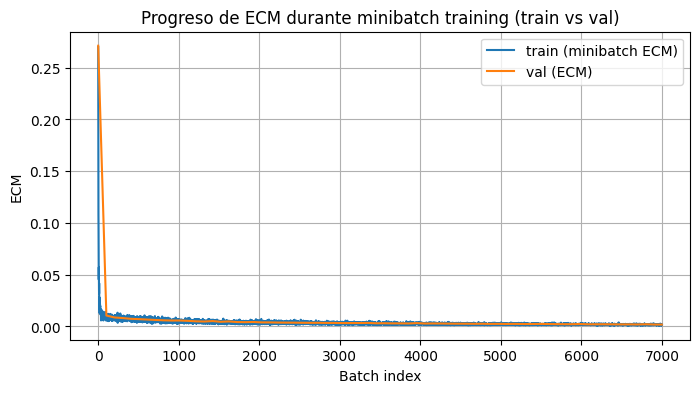

In [ ]:
# --- Entrenamiento para la función f(x,y,z) usando X_train / y_train ---
# Convertir a ndarray y asegurar formas correctas (X: n x 3, y: n x 1)
X_train_arr = np.asarray(X_train, dtype=float)
y_train_arr = np.asarray(y_train, dtype=float).reshape(-1, 1)
X_test_arr = np.asarray(X_test, dtype=float)
y_test_arr = np.asarray(y_test, dtype=float).reshape(-1, 1)

print('X_train shape =', X_train_arr.shape, 'y_train shape =', y_train_arr.shape)
print('X_test shape =', X_test_arr.shape, 'y_test shape =', y_test_arr.shape)

# hay que ajustar la salida para que esté entre 0 y 1, no -3 y 3
y_train_arr = (y_train_arr + 3) / 6
y_test_arr = (y_test_arr + 3) / 6

# Crear un modelo para 3 entradas (ejemplo: 30 neuronas ocultas)
model_f = perceptron_multicapa(capas=[30, 1], dim_entrada=3)

# Entrenamiento con minibatches: tamanio de batch = 40 (configurable)
# Pasamos X_test/y_test para evaluar progreso en validación, verbose para ver avance resumido
hist = model_f.minibatch_training(X_train_arr, y_train_arr, tamanio=40, veces=5, lr=0.5, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=100, verbose=True)

print('Entrenamiento de model_f completado.')
print('Últimos 5 train losses:', hist['train'][-5:])
print('Últimos 5 val losses:', hist['val'][-5:])

# Graficar progreso (train y validation)
plt.figure(figsize=(8,4))
x_train = np.arange(len(hist['train']))
# mapear val a indices aproximados a lo largo del eje de train para visual comparativa
if len(hist['val'])>0:
    x_val = np.linspace(0, len(hist['train'])-1, len(hist['val']))
    plt.plot(x_train, hist['train'], label='train (minibatch ECM)')
    plt.plot(x_val, hist['val'], label='val (ECM)')
else:
    plt.plot(x_train, hist['train'], label='train (minibatch ECM)')
plt.xlabel('Batch index')
plt.ylabel('ECM')
plt.title('Progreso de ECM durante minibatch training (train vs val)')
plt.legend()
plt.grid(True)
plt.show()



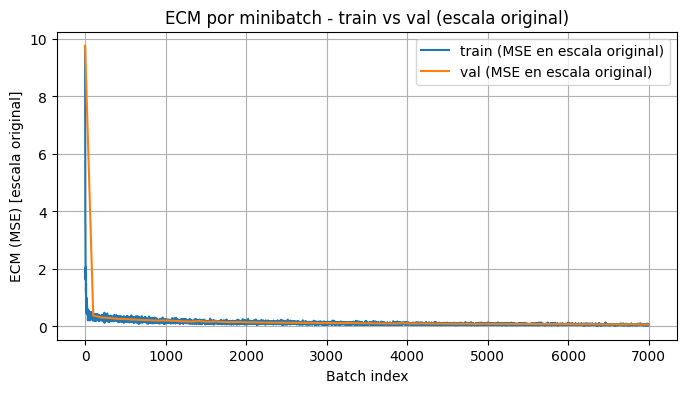

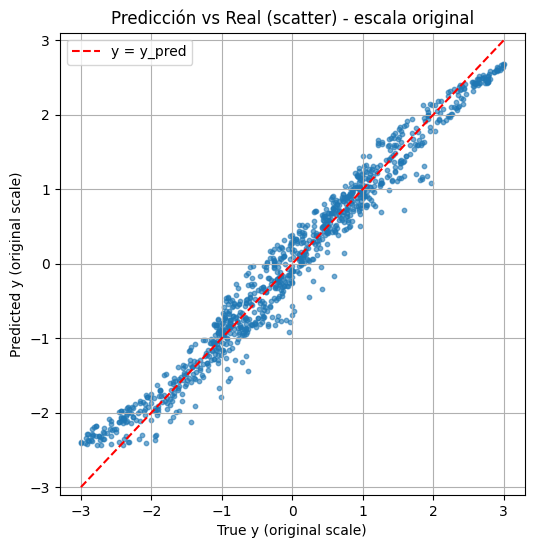

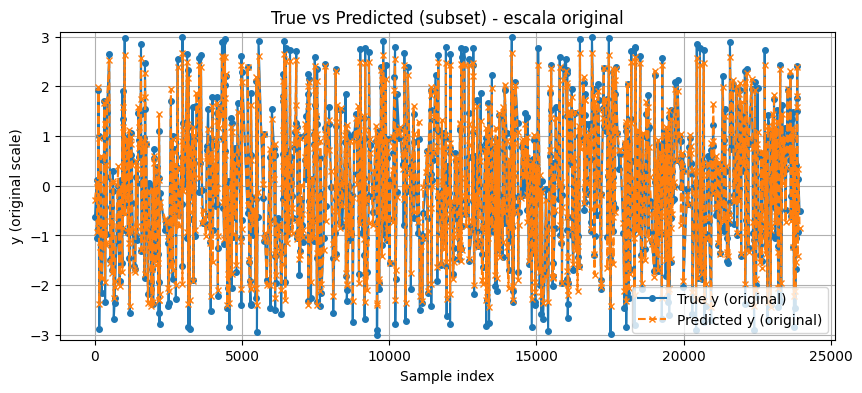

In [ ]:
# Gráficos de progreso y comparación predicción vs real
# Helpers de escala (lineal entre espacio original y [0,1])
# Si cambias la transformación, actualizá estas funciones.
def scale_to_01(y):
    """Escala y (vector) del rango original [-3,3] a [0,1]."""
    y = np.asarray(y).reshape(-1)
    return (y + 3.0) / 6.0


def inverse_scale(y01):
    """Vuelve de [0,1] al rango original [-3,3]."""
    y01 = np.asarray(y01).reshape(-1)
    return y01 * 6.0 - 3.0


def plot_train_val(hist, titulo='ECM - train vs val'):
    """Plotea la historia de ECM. Hist contiene ECM calculados sobre targets escalados [0,1].
    Para mostrar en la escala original se multiplica la MSE por el factor de escala^2
    (si y_orig = a * y_scaled + b, entonces MSE_orig = a^2 * MSE_scaled).
    """
    plt.figure(figsize=(8,4))
    train = np.array(hist.get('train', []))
    val = np.array(hist.get('val', []))
    # factor para pasar MSE de escala [0,1] a original [-3,3]: a = 6 -> a^2 = 36
    factor = 6.0 ** 2
    train_orig = train * factor
    val_orig = val * factor
    x_train = np.arange(len(train))
    plt.plot(x_train, train_orig, label='train (MSE en escala original)')
    if val.size > 0:
        x_val = np.linspace(0, len(train)-1, len(val)) if len(train)>0 else np.arange(len(val))
        plt.plot(x_val, val_orig, label='val (MSE en escala original)')
    plt.xlabel('Batch index')
    plt.ylabel('ECM (MSE) [escala original]')
    plt.title(titulo)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_pred_vs_true(X, Y, model, n_samples=500, random_seed=0):
    """Muestra dos gráficos en la escala original ([-3,3]):
    - scatter: pred vs true (línea y=x)
    - series: valores reales vs predicciones para un subconjunto de índices
    Asume que Y recibido está en la misma escala que se usó para entrenar (es decir, [0,1]).
    """
    X_arr = np.asarray(X)
    Y_arr = np.asarray(Y).reshape(-1)
    preds = model.predecir(X_arr).reshape(-1)

    # Convertir ambas series a escala original
    Y_un = inverse_scale(Y_arr)
    preds_un = inverse_scale(preds)

    N = len(Y_un)
    if N == 0:
        print('No hay muestras para graficar')
        return
    rng = np.random.default_rng(random_seed)
    if n_samples is None or n_samples >= N:
        idx = np.arange(N)
    else:
        idx = rng.choice(N, size=n_samples, replace=False)

    # scatter pred vs true (en escala original)
    plt.figure(figsize=(6,6))
    plt.scatter(Y_un[idx], preds_un[idx], alpha=0.6, s=10)
    mn = min(Y_un[idx].min(), preds_un[idx].min())
    mx = max(Y_un[idx].max(), preds_un[idx].max())
    plt.plot([mn, mx], [mn, mx], 'r--', label='y = y_pred')
    plt.xlabel('True y (original scale)')
    plt.ylabel('Predicted y (original scale)')
    plt.title('Predicción vs Real (scatter) - escala original')
    plt.legend()
    plt.grid(True)
    plt.ylim(-3.1, 3.1)
    plt.show()

    # series plot for same indices sorted
    idx_sorted = np.sort(idx)
    plt.figure(figsize=(10,4))
    plt.plot(idx_sorted, Y_un[idx_sorted], 'o-', label='True y (original)', markersize=4)
    plt.plot(idx_sorted, preds_un[idx_sorted], 'x--', label='Predicted y (original)', markersize=4)
    plt.xlabel('Sample index')
    plt.ylabel('y (original scale)')
    plt.title('True vs Predicted (subset) - escala original')
    plt.legend()
    plt.grid(True)
    plt.ylim(-3.1, 3.1)
    plt.show()


def show_prediction_for_xyz(xyz, model):
    """Recibe xyz = [x,y,z] y muestra la predicción del modelo en la escala original junto al valor real."""
    arr = np.asarray(xyz, dtype=float).reshape(1, -1)
    pred_scaled = model.predecir(arr).reshape(-1)[0]
    pred_orig = float(inverse_scale(pred_scaled))
    real = float(np.sin(xyz[0]) + np.cos(xyz[1]) + xyz[2])
    print(f'Entrada (x,y,z): {xyz}')
    print(f'Predicción (escala original): {pred_orig:.6f}')
    print(f'Valor real (escala original): {real:.6f}')
    return pred_orig


# Uso: trazamos train/val si existe el historial 'hist' retornado por minibatch_training
try:
    plot_train_val(hist, 'ECM por minibatch - train vs val (escala original)')
except NameError:
    print('Variable hist no encontrada. Ejecutá la celda de entrenamiento antes de graficar.')

# Uso: comparar pred/true en test set (se asume que y_test_arr está escalado a [0,1])
try:
    plot_pred_vs_true(X_test_arr, y_test_arr, model_f, n_samples=1000)
except NameError:
    print('Asegurate de haber entrenado model_f y de tener X_test_arr / y_test_arr en memoria.')

# Ejemplo: pedir predicción para una muestra concreta (descomentar y editar si querés probar)
# ejemplo_xyz = [0.1, 1.2, -1]
# show_prediction_for_xyz(ejemplo_xyz, model_f)


--- Inciso (a): entrenamiento en dataset grande (ejemplo) ---
pass 1/5 batch 1/1400 train_loss=0.275875 val_loss=0.296364
pass 1/5 batch 141/1400 train_loss=0.043425
pass 1/5 batch 281/1400 train_loss=0.015805
pass 1/5 batch 421/1400 train_loss=0.010386
pass 1/5 batch 561/1400 train_loss=0.010314
pass 1/5 batch 701/1400 train_loss=0.009986 val_loss=0.009478
pass 1/5 batch 841/1400 train_loss=0.007764
pass 1/5 batch 981/1400 train_loss=0.006073
pass 1/5 batch 1121/1400 train_loss=0.010413
pass 1/5 batch 1261/1400 train_loss=0.006192
pass 2/5 batch 1/1400 train_loss=0.004098 val_loss=0.006765
pass 2/5 batch 141/1400 train_loss=0.007514
pass 2/5 batch 281/1400 train_loss=0.004394
pass 2/5 batch 421/1400 train_loss=0.005356
pass 2/5 batch 561/1400 train_loss=0.006144
pass 2/5 batch 701/1400 train_loss=0.004382 val_loss=0.005859
pass 2/5 batch 841/1400 train_loss=0.005458
pass 2/5 batch 981/1400 train_loss=0.005329
pass 2/5 batch 1121/1400 train_loss=0.005112
pass 2/5 batch 1261/1400 train

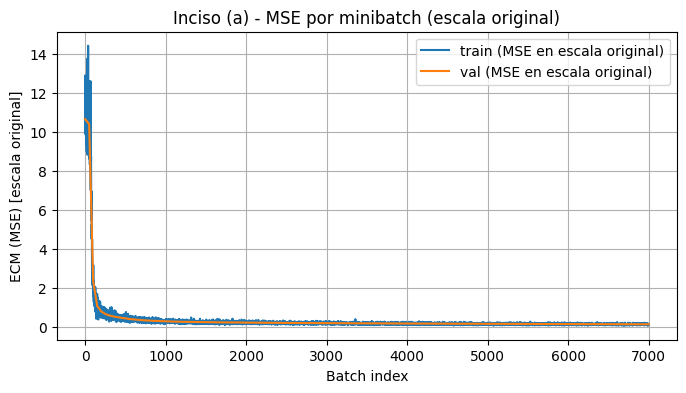

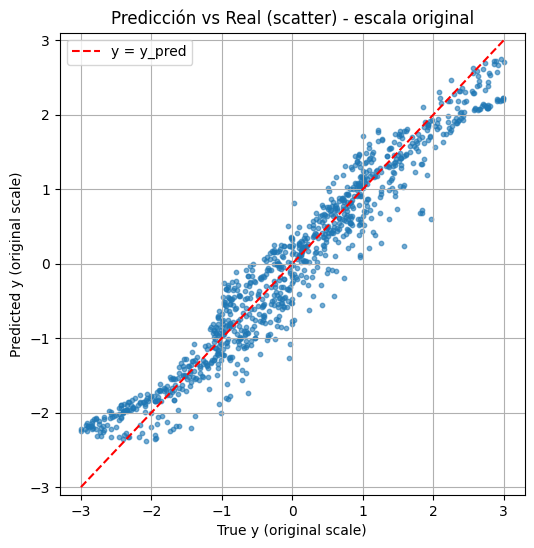

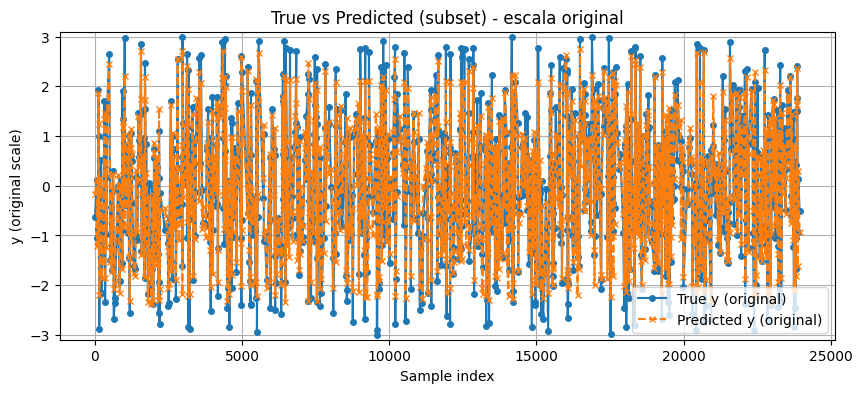


Ejemplo:
Entrada (x,y,z): [0.5, 1.0, -1]
Predicción (escala original): -0.241579
Valor real (escala original): 0.019728

--- Inciso (b): comparar minibatch size = 40 vs = 1 (con solo 40 muestras de entrenamiento) ---
Algunas Y (original scale) del subset de 40:
[ 1.66658529 -1.04815263  1.61350102  1.71129796  0.73534867  0.15339755]


/tmp/ipython-input-3400245446.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_orig = float(inverse_scale(pred_scaled))


Tiempo experimento b1 (batch=40): 92.51s
Len train history b1: 200 Len val history b1: 200


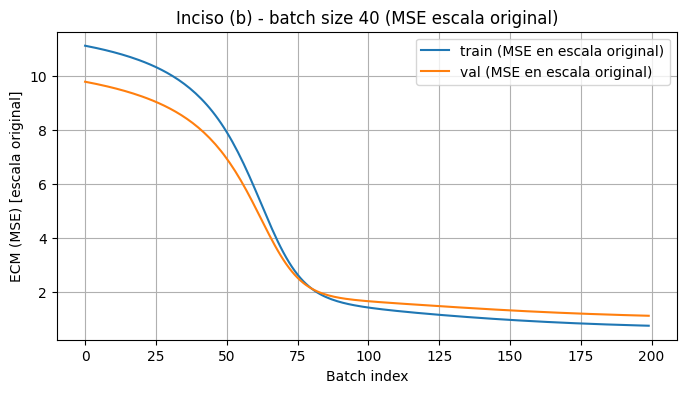

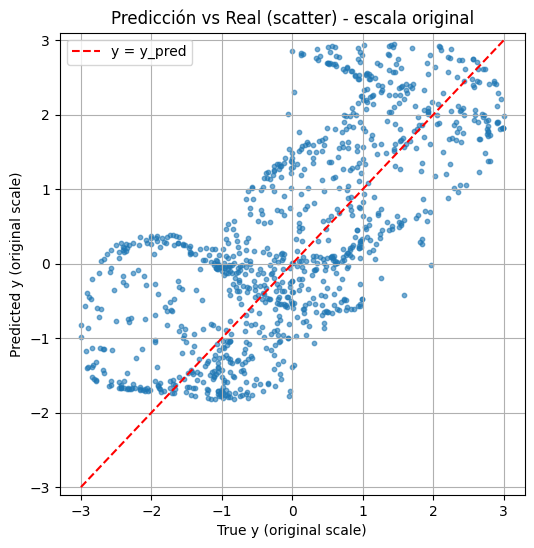

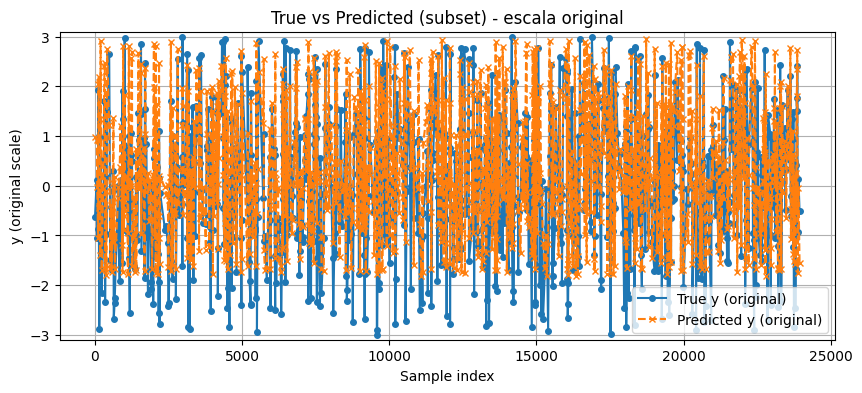

MSE (original scale) para b1 - train (subset 40): 0.733787, test: 1.103527
Tiempo experimento b2 (batch=1): 93.32s
Len train history b2: 8000 Len val history b2: 200


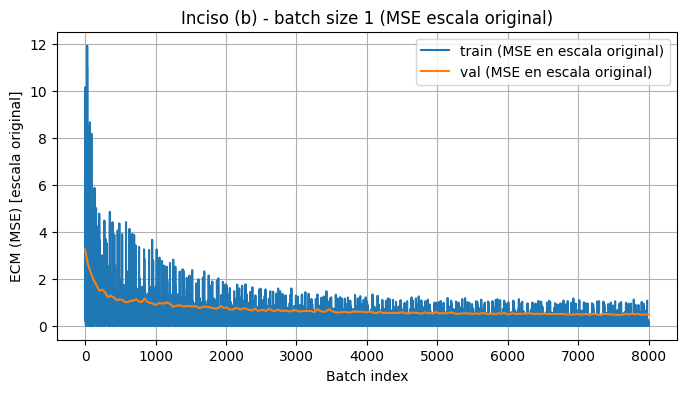

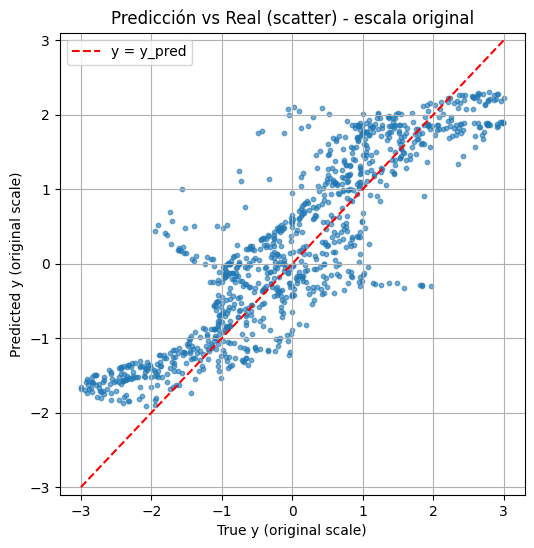

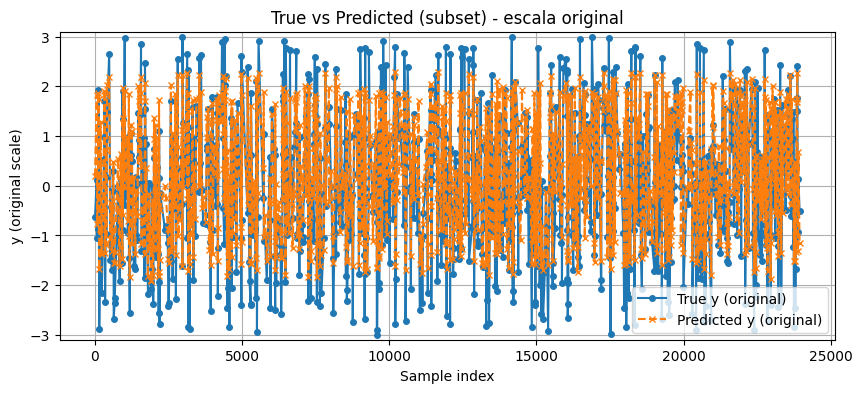

MSE (original scale) para b2 - train (subset 40): 0.156075, test: 0.486344

Resumen comparativo (MSE en escala original):
  batch=40 -> train(subset40)=0.733787, test=1.103527
  batch=1  -> train(subset40)=0.156075, test=0.486344

Observaciones:
- Con batch=40 (entrenamiento por batches del tamaño del dataset pequeño) suele converger de forma más estable pero puede sobreajustar si damos muchas pasadas.
- Con batch=1 (estocástico) la trayectoria del error es más ruidosa; puede generalizar distinto según la tasa de aprendizaje y la cantidad de pasos.


In [ ]:
# === Experimentos: Inciso (a) y (b) ===
# - (a) Entrenar en el dataset completo y mostrar evolución de error y predicciones
# - (b) Tomar un conjunto de entrenamiento con 40 muestras y comparar minibatch size = 40 vs = 1

import time

# Comprobaciones básicas
try:
    X_train_arr
    y_train_arr
    X_test_arr
    y_test_arr
except NameError:
    raise NameError('Ejecutá antes las celdas que generan y escalan X_train_arr / y_train_arr / X_test_arr / y_test_arr')

rng = np.random.default_rng(42)

# ---- Inciso (a): entrenar con el dataset grande (ya escalado a [0,1]) ----
print('\n--- Inciso (a): entrenamiento en dataset grande (ejemplo) ---')
start = time.time()
model_a = perceptron_multicapa(capas=[30,1], dim_entrada=3)
# parámetros moderados, rápido de correr: 5 pases, minibatch 40
# los epochs deben ser 1 porque queremos mostrar el minibatch solo 1 vez
hist_a = model_a.minibatch_training(X_train_arr, y_train_arr, tamanio=40, veces=5, lr=0.5, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=50, verbose=True)
print(f'Tiempo entrenamiento (a): {time.time()-start:.2f}s')
print('Últimos 5 train losses (scaled):', hist_a['train'][-5:])
if len(hist_a['val'])>0:
    print('Últimos 5 val losses (scaled):', hist_a['val'][-5:])

# Graficar (se muestran en escala original mediante las funciones que añadimos)
plot_train_val(hist_a, 'Inciso (a) - MSE por minibatch (escala original)')
plot_pred_vs_true(X_test_arr, y_test_arr, model_a, n_samples=1000)

# Ejemplo de predicción para una muestra concreta
example_xyz = [0.5, 1.0, -1]
print('\nEjemplo:')
show_prediction_for_xyz(example_xyz, model_a)

# ---- Inciso (b): usar solo 40 muestras de entrenamiento y comparar minibatch sizes ----
print('\n--- Inciso (b): comparar minibatch size = 40 vs = 1 (con solo 40 muestras de entrenamiento) ---')
# seleccionar 40 muestras aleatorias del conjunto de entrenamiento escalado
n_small = 40
N_train = X_train_arr.shape[0]
idx_small = rng.choice(N_train, size=n_small, replace=False)
X_small = X_train_arr[idx_small]
y_small = y_train_arr[idx_small]

# Mostrar algunos valores reales (desescalados) para verificar rango
print('Algunas Y (original scale) del subset de 40:')
print(inverse_scale(y_small[:6].reshape(-1)))

# Experimento 1: minibatch = 40 (batch gradient descent w.r.t dataset_small)
model_b1 = perceptron_multicapa(capas=[30,1], dim_entrada=3)
start = time.time()
# usamos muchas pasadas para ver sobreajuste/variación, entrenar con epochs=1 por minibatch
hist_b1 = model_b1.minibatch_training(X_small, y_small, tamanio=40, veces=200, lr=0.1, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=20, verbose=False)
print(f'Tiempo experimento b1 (batch=40): {time.time()-start:.2f}s')
print('Len train history b1:', len(hist_b1['train']), 'Len val history b1:', len(hist_b1['val']))

# Graficar
plot_train_val(hist_b1, 'Inciso (b) - batch size 40 (MSE escala original)')
plot_pred_vs_true(X_test_arr, y_test_arr, model_b1, n_samples=1000)

# Evaluación numérica final (MSE en escala original)
def mse_original(model, X, y_scaled):
    preds = model.predecir(np.asarray(X)).reshape(-1)
    preds_orig = inverse_scale(preds)
    y_orig = inverse_scale(np.asarray(y_scaled).reshape(-1))
    return float(np.mean((preds_orig - y_orig)**2))

mse_b1_train = mse_original(model_b1, X_small, y_small)
mse_b1_test = mse_original(model_b1, X_test_arr, y_test_arr)
print(f'MSE (original scale) para b1 - train (subset 40): {mse_b1_train:.6f}, test: {mse_b1_test:.6f}')

# Experimento 2: minibatch = 1 (stochastic)
model_b2 = perceptron_multicapa(capas=[30,1], dim_entrada=3)
start = time.time()
hist_b2 = model_b2.minibatch_training(X_small, y_small, tamanio=1, veces=200, lr=0.1, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=200, verbose=False)
print(f'Tiempo experimento b2 (batch=1): {time.time()-start:.2f}s')
print('Len train history b2:', len(hist_b2['train']), 'Len val history b2:', len(hist_b2['val']))

plot_train_val(hist_b2, 'Inciso (b) - batch size 1 (MSE escala original)')
plot_pred_vs_true(X_test_arr, y_test_arr, model_b2, n_samples=1000)

mse_b2_train = mse_original(model_b2, X_small, y_small)
mse_b2_test = mse_original(model_b2, X_test_arr, y_test_arr)
print(f'MSE (original scale) para b2 - train (subset 40): {mse_b2_train:.6f}, test: {mse_b2_test:.6f}')

# Resumen comparativo
print('\nResumen comparativo (MSE en escala original):')
print(f'  batch=40 -> train(subset40)={mse_b1_train:.6f}, test={mse_b1_test:.6f}')
print(f'  batch=1  -> train(subset40)={mse_b2_train:.6f}, test={mse_b2_test:.6f}')

print('\nObservaciones:')
print('- Con batch=40 (entrenamiento por batches del tamaño del dataset pequeño) suele converger de forma más estable pero puede sobreajustar si damos muchas pasadas.')
print('- Con batch=1 (estocástico) la trayectoria del error es más ruidosa; puede generalizar distinto según la tasa de aprendizaje y la cantidad de pasos.')

# Fin de celda de experimentos


In [ ]:
# === Experimentos: Inciso (a) y (b) ===
# - (a) Entrenar en el dataset completo y mostrar evolución de error y predicciones
# - (b) Tomar un conjunto de entrenamiento con 40 muestras y comparar minibatch size = 40 vs = 1

import time

# Comprobaciones básicas
try:
    X_train_arr
    y_train_arr
    X_test_arr
    y_test_arr
except NameError:
    raise NameError('Ejecutá antes las celdas que generan y escalan X_train_arr / y_train_arr / X_test_arr / y_test_arr')

rng = np.random.default_rng(42)

# ---- Inciso (a): entrenar con el dataset grande (ya escalado a [0,1]) ----
print('\n--- Inciso (a): entrenamiento en dataset grande (ejemplo) ---')
start = time.time()
model_a = perceptron_multicapa(capas=[10,1], dim_entrada=3)
# parámetros moderados, rápido de correr: 5 pases, minibatch 40
# los epochs deben ser 1 porque queremos mostrar el minibatch solo 1 vez
hist_a = model_a.minibatch_training(X_train_arr, y_train_arr, tamanio=100, veces=10, lr=0.5, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=50, verbose=True)
print(f'Tiempo entrenamiento (a): {time.time()-start:.2f}s')
print('Últimos 5 train losses (scaled):', hist_a['train'][-5:])
if len(hist_a['val'])>0:
    print('Últimos 5 val losses (scaled):', hist_a['val'][-5:])

# Graficar (se muestran en escala original mediante las funciones que añadimos)
plot_train_val(hist_a, 'Inciso (a) - MSE por minibatch (escala original)')
plot_pred_vs_true(X_test_arr, y_test_arr, model_a, n_samples=1000)

# Ejemplo de predicción para una muestra concreta
example_xyz = [0.5, 1.0, -1]
print('\nEjemplo:')
show_prediction_for_xyz(example_xyz, model_a)


# ---- Inciso (a): entrenar con el dataset grande (ya escalado a [0,1]) ----
print('\n--- Inciso (a): entrenamiento en dataset grande (ejemplo) ---')
start = time.time()
model_a = perceptron_multicapa(capas=[10,1], dim_entrada=3)
# parámetros moderados, rápido de correr: 5 pases, minibatch 40
# los epochs deben ser 1 porque queremos mostrar el minibatch solo 1 vez
hist_a = model_a.minibatch_training(X_train_arr, y_train_arr, tamanio=1000, veces=10, lr=0.5, epochs=1, X_val=X_test_arr, Y_val=y_test_arr, eval_every=50, verbose=True)
print(f'Tiempo entrenamiento (a): {time.time()-start:.2f}s')
print('Últimos 5 train losses (scaled):', hist_a['train'][-5:])
if len(hist_a['val'])>0:
    print('Últimos 5 val losses (scaled):', hist_a['val'][-5:])

# Graficar (se muestran en escala original mediante las funciones que añadimos)
plot_train_val(hist_a, 'Inciso (a) - MSE por minibatch (escala original)')
plot_pred_vs_true(X_test_arr, y_test_arr, model_a, n_samples=1000)

# Ejemplo de predicción para una muestra concreta
example_xyz = [0.5, 1.0, -1]
print('\nEjemplo:')
show_prediction_for_xyz(example_xyz, model_a)


